In [42]:
from os import path
import os

import astropy.coordinates as coord
from astropy.constants import G
from astropy.io import fits
from astropy.table import Table, QTable, join
from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import yaml
import tables as tb

from hq.config import Config
from hq.plot import plot_two_panel, plot_phase_fold
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius
from hq.mass_helpers import get_martig_mass

import thejoker as tj

from twobody.transforms import get_m2_min

In [2]:
plot_path = path.expanduser('~/projects/bh/plots/')
data_path = path.expanduser('~/projects/bh/data/')

In [3]:
c = Config.from_run_name('dr16')

In [19]:
allstar, allvisit = c.load_alldata()

In [26]:
master = QTable.read(c.metadata_path)
master = join(master, allstar, keys='APOGEE_ID')

TODO: where can I get better mass estimates?

In [27]:
mass_tbl = Table.read('../data/shite_m1_estimates.fits')
_, idx = np.unique(mass_tbl['APOGEE_ID'], return_index=True)
mass_tbl = mass_tbl[idx]
master = join(master, mass_tbl, keys='APOGEE_ID')

In [141]:
gaia = Table.read('../data/allStar-r12-gaiadr2.fits')
_, idx = np.unique(gaia['apogee_id'], return_index=True)
gaia = gaia[idx]
gaia.rename_column('apogee_id', 'APOGEE_ID')
master = join(master, gaia, keys='APOGEE_ID')

In [142]:
# thompson_id = '2M05215658+4359220'
# master[master['APOGEE_ID'] == thompson_id]

In [143]:
# mask = (((master['STARFLAG'] & np.sum(2**np.array([2, 9]))) == 0) & # BRIGHT_NEIGHBOR, PERSIST_HIGH
#         ((master['ASPCAPFLAG'] & np.sum(2**np.array([7]))) == 0)) # STAR_WARN
mask = (((master['STARFLAG'] & np.sum(2**np.array([2, 9]))) == 0)) # BRIGHT_NEIGHBOR, PERSIST_HIGH
t = master[mask]

_, idx = np.unique(t['APOGEE_ID'], return_index=True)
t = t[idx]

len(t)

187243

In [144]:
# llr = t['max_unmarginalized_ln_likelihood'] - t['robust_constant_ln_likelihood']
llr = t['kepler_ln_evidence'] - t['constant_ln_evidence']

In [147]:
llr_mask = ((llr > 4) & 
            (np.isfinite(t['m1']) &
             (t['n_visits'] >= 3)))
llr_mask.sum()

11375

In [148]:
def m_f(P, K, e):
    """Binary mass function."""
    mf_circ = P * K**3 / (2*np.pi * G)
    return mf_circ.to(u.Msun) * (1 - e**2)**1.5

## Select the candidates

In [149]:
joker_f = tb.open_file(c.joker_results_path, 'r')
mcmc_f = tb.open_file(c.mcmc_results_path, 'r')

In [150]:
with tb.open_file(c.mcmc_results_path, 'r') as mcmc_f, tb.open_file(c.joker_results_path, 'r') as joker_f:
    cool_ids = []
    m2_mins = []
    m1s = []
    for row in tqdm(t[llr_mask]):
        apogee_id = row['APOGEE_ID']
        m1 = row['m1'] * u.Msun

        if row['mcmc_success']:
            g = mcmc_f.get_node(f'/{apogee_id}')
        else:
            g = joker_f.get_node(f'/{apogee_id}')

        P = g.samples.read(field='P') * u.day
        K = g.samples.read(field='K') * u.km/u.s
        e = g.samples.read(field='e')

        # data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apogee_id])
        # _ = plot_rv_curves(samples=samples, data=data)

        m2_min = get_m2_min(np.repeat(m1, len(P)), m_f(P, K, e))
        if np.percentile(m2_min, 5) > 1. and 0.5 < m1.value < 2.5:  # Magic numbers all around!            
            cool_ids.append(apogee_id)
            m2_mins.append(m2_min)
            m1s.append(m1)

    m1s = u.Quantity(m1s)


  3%|▎         | 303/11375 [00:25<13:48, 13.36it/s]


  5%|▌         | 613/11375 [00:50<15:58, 11.22it/s]


  8%|▊         | 914/11375 [01:16<15:16, 11.42it/s]


 11%|█         | 1212/11375 [01:42<14:45, 11.48it/s]


 13%|█▎        | 1510/11375 [02:07<11:31, 14.26it/s]


 16%|█▌        | 1808/11375 [02:33<12:01, 13.26it/s]


 18%|█▊        | 2103/11375 [02:58<12:19, 12.54it/s]


 21%|██        | 2398/11375 [03:25<14:20, 10.43it/s]


 24%|██▎       | 2693/11375 [03:51<13:30, 10.71it/s]


 26%|██▌       | 2983/11375 [04:17<17:02,  8.21it/s]


 29%|██▊       | 3258/11375 [04:44<12:02, 11.23it/s]


 31%|███▏      | 3555/11375 [05:12<13:55,  9.36it/s]


 34%|███▍      | 3843/11375 [05:39<12:10, 10.31it/s]


 36%|███▋      | 4129/11375 [06:07<13:23,  9.02it/s]


 39%|███▉      | 4409/11375 [06:33<12:57,  8.96it/s]


 41%|████      | 4660/11375 [07:00<14:42,  7.61it/s]


 43%|████▎     | 4926/11375 [07:29<11:17,  9.52it/s]


 46%|████▌     | 5220/11375 [07:58<09:43, 10.55it/s]


 49%|████▊     | 5521/11375 [08:25<08:18, 11.75it/s]


 51%|█████     | 5819/11375 [08:52<08:36, 10.75it/s]


 54%|█████▍    | 6116/11375 [09:19<08:18, 10.56it/s]


 56%|█████▌    | 6383/11375 [09:48<10:27,  7.96it/s]


 59%|█████▊    | 6657/11375 [10:15<06:58, 11.27it/s]


 61%|██████    | 6958/11375 [10:41<05:17, 13.92it/s]


 63%|██████▎   | 7215/11375 [11:07<05:53, 11.77it/s]


 66%|██████▌   | 7468/11375 [11:33<06:37,  9.83it/s]


 68%|██████▊   | 7727/11375 [11:59<06:13,  9.77it/s]


 70%|███████   | 8003/11375 [12:25<05:05, 11.03it/s]


 73%|███████▎  | 8286/11375 [12:50<05:26,  9.45it/s]


 75%|███████▍  | 8518/11375 [13:15<06:24,  7.43it/s]


 77%|███████▋  | 8810/11375 [13:43<06:26,  6.63it/s]


 80%|███████▉  | 9047/11375 [14:07<04:08,  9.36it/s]


 82%|████████▏ | 9324/11375 [14:34<02:51, 11.99it/s]


 84%|████████▍ | 9584/11375 [15:01<03:21,  8.90it/s]


 86%|████████▌ | 9800/11375 [15:26<03:21,  7.81it/s]


 88%|████████▊ | 10049/11375 [15:52<02:06, 10.51it/s]


 91%|█████████ | 10323/11375 [16:17<01:29, 11.81it/s]


 93%|█████████▎| 10575/11375 [16:43<02:00,  6.66it/s]


 95%|█████████▌| 10809/11375 [17:07<01:10,  8.01it/s]


 97%|█████████▋| 11062/11375 [17:33<00:30, 10.25it/s]


 99%|█████████▉| 11306/11375 [17:58<00:07,  8.73it/s]


100%|██████████| 11375/11375 [18:04<00:00, 10.48it/s]


In [151]:
len(m1s)

58

In [152]:
all_samples = []
with h5py.File(c.joker_results_path, 'r') as _joker_f:
    with h5py.File(c.mcmc_results_path, 'r') as _mcmc_f:
        for apogee_id in cool_ids:
            row = t[t['APOGEE_ID'] == apogee_id]
            
            if row['mcmc_success']:
                samples = tj.JokerSamples.read(_mcmc_f[apogee_id])
            else:
                samples = tj.JokerSamples.read(_joker_f[apogee_id])
            
            all_samples.append(samples)

In [153]:
H, xe, ye = np.histogram2d(t['TEFF'], t['LOGG'], 
                           bins=(np.linspace(3000, 8000, 128),
                                 np.linspace(0, 5, 64)));

In [125]:
from matplotlib.gridspec import GridSpec

2M15420836+4500530
2M16050296+4436428
2M16113909+2501000
2M16171557+5036451
2M16241055+4008203
2M17021700-2145531
2M17043578+3445328
2M17265685+5701562
2M18580861+0003492
2M19134739-0133112
2M19191595-1126321
2M19315429+4232516
2M20593168+5559227
2M21273727+1112577
2M21301515+1307000
2M21311504+1219444
2M22001521+5559468
2M23141285+3519594


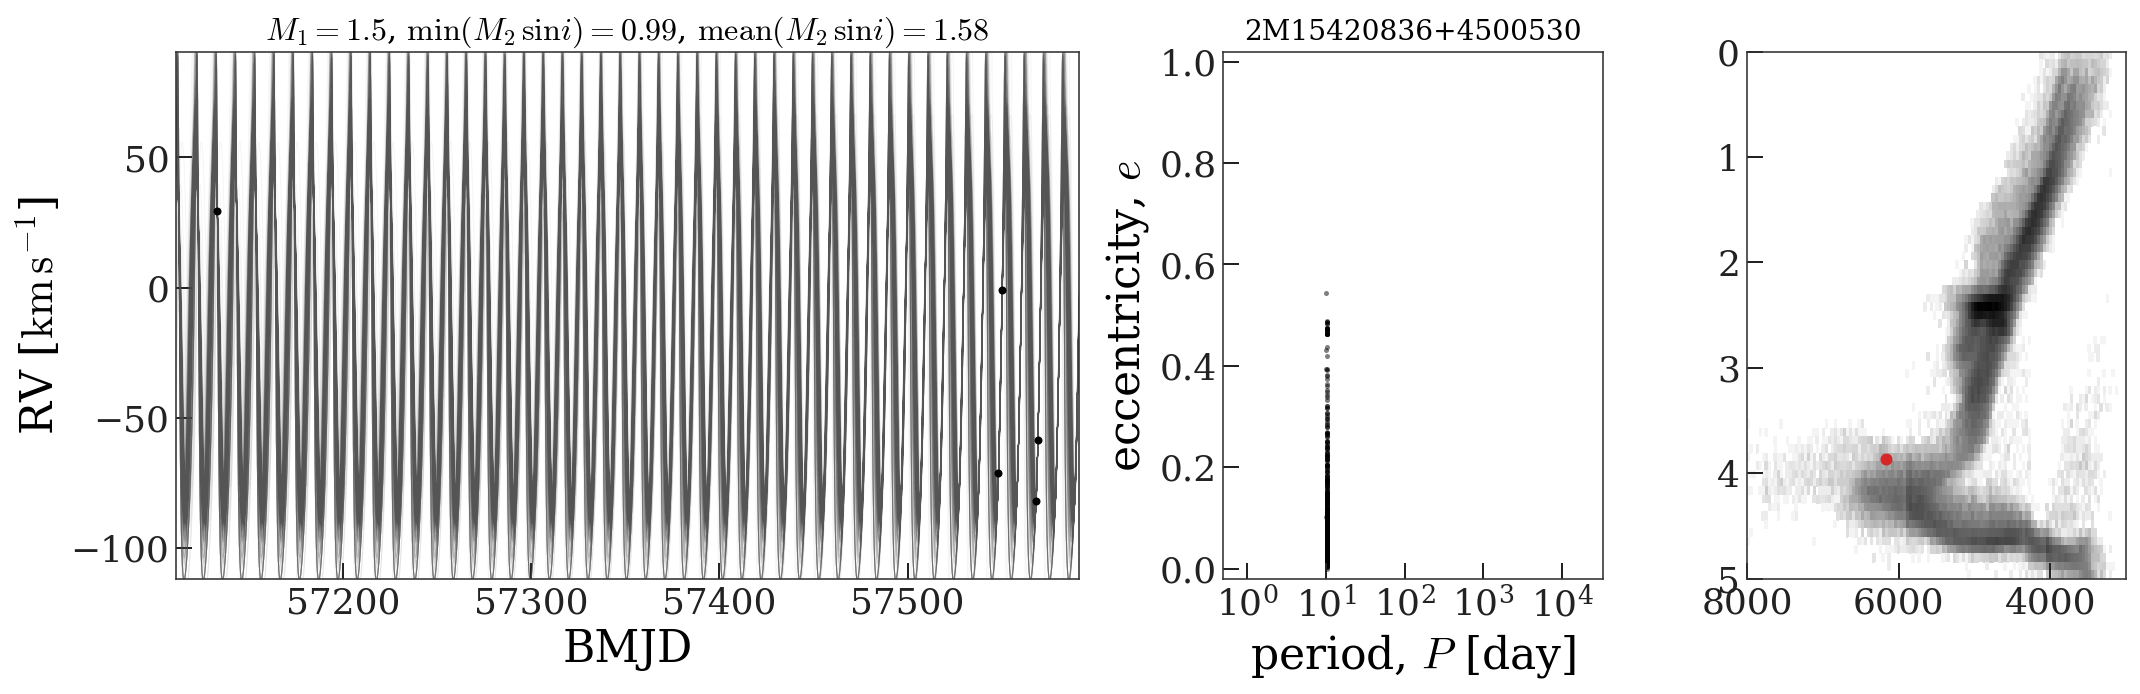

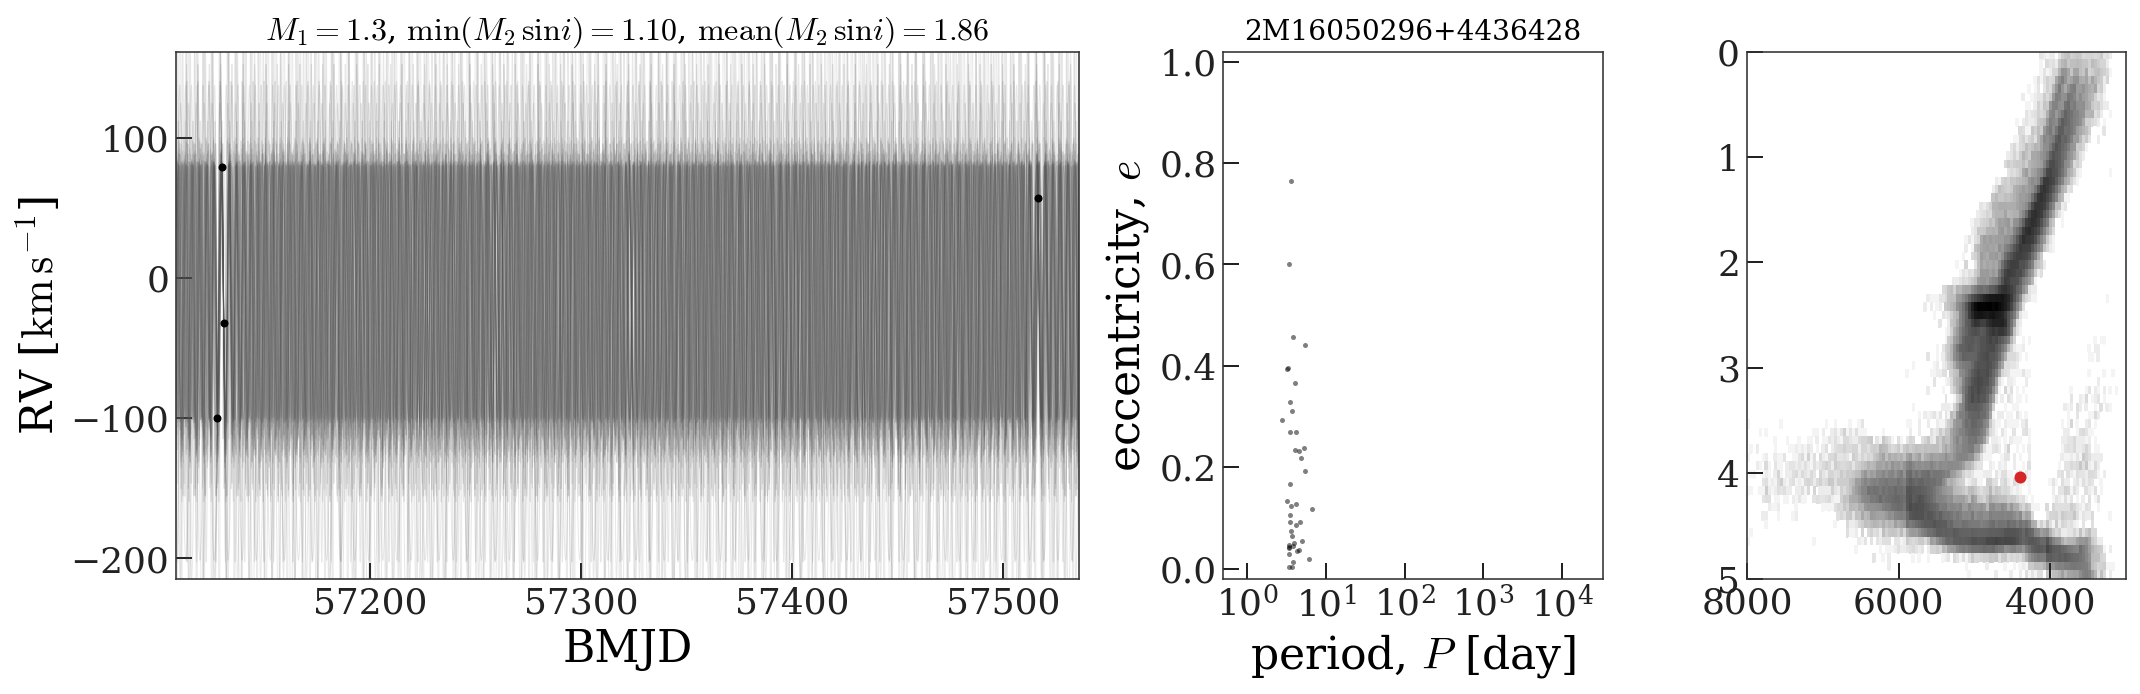

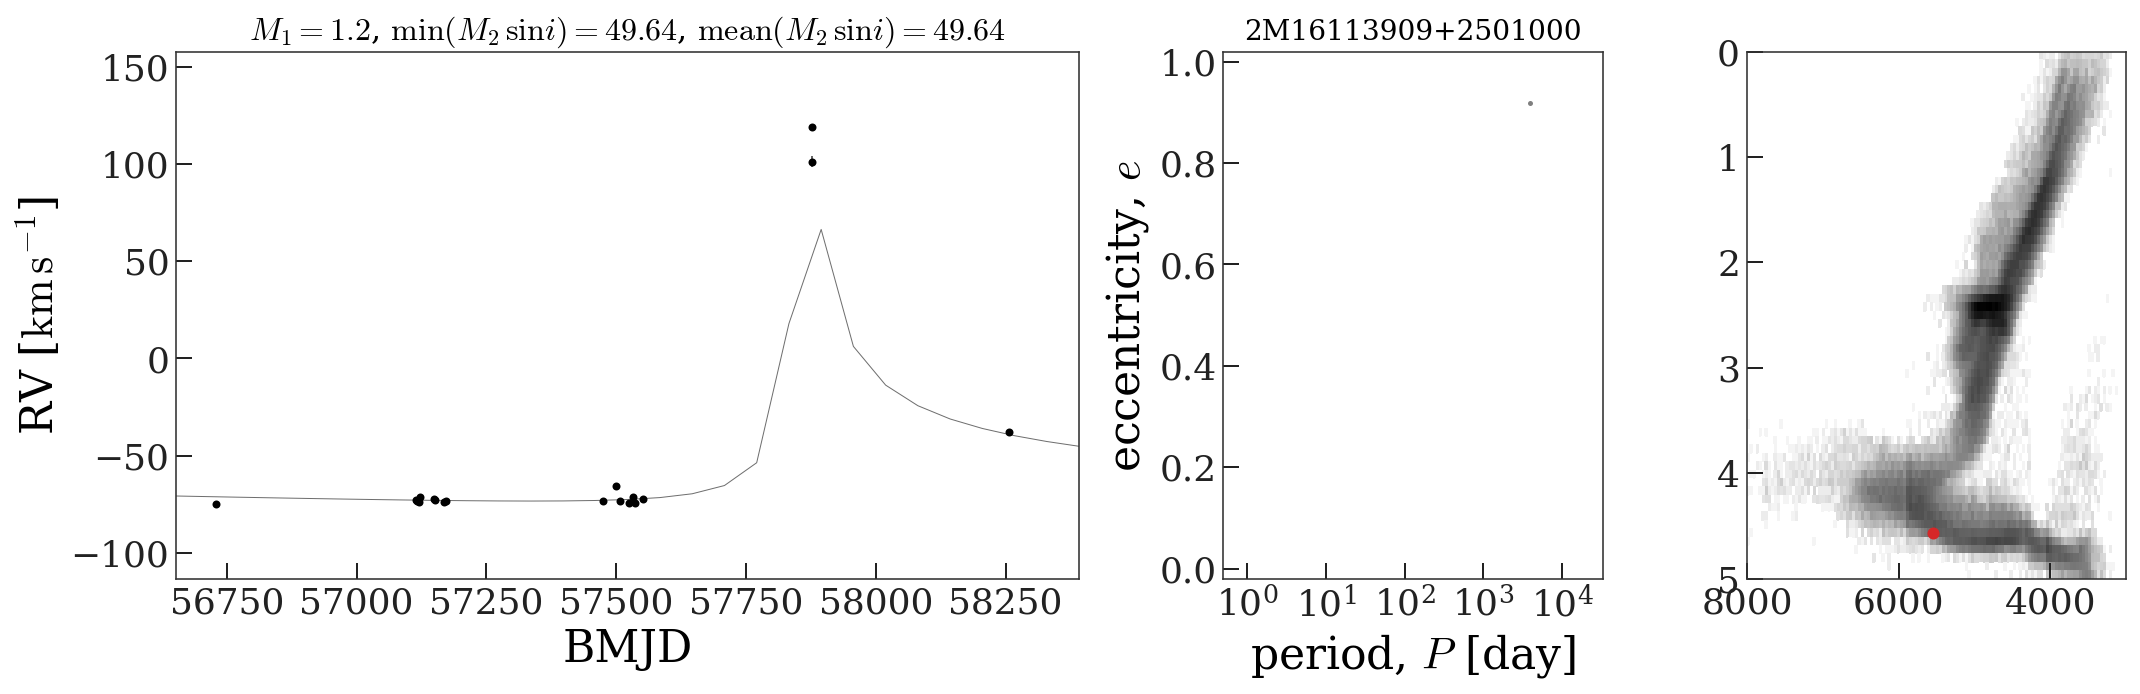

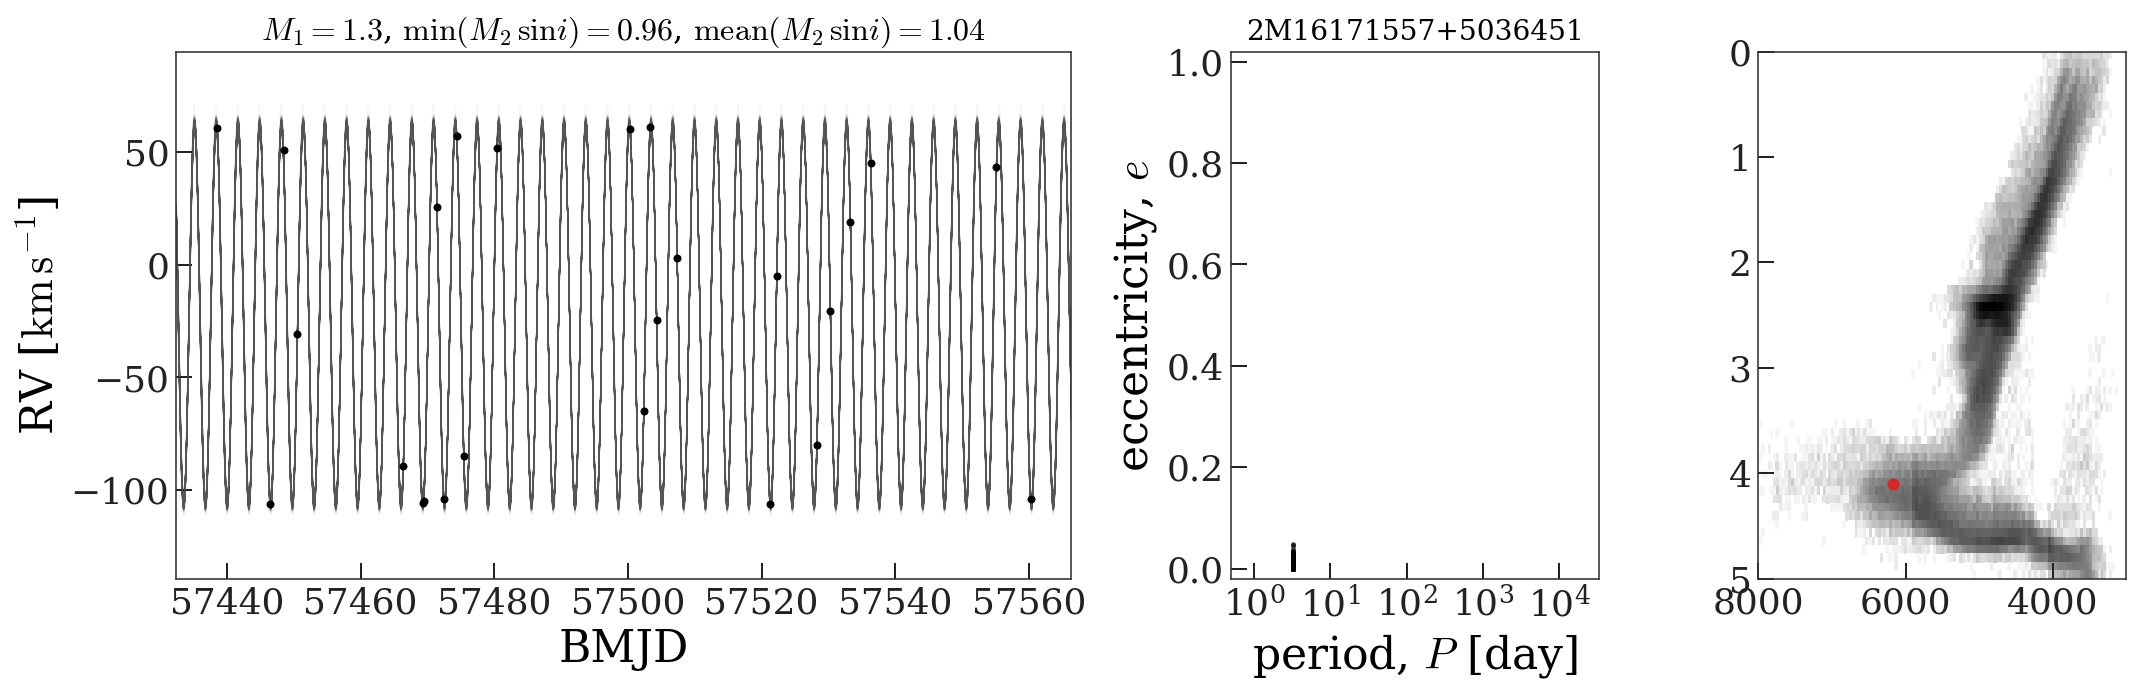

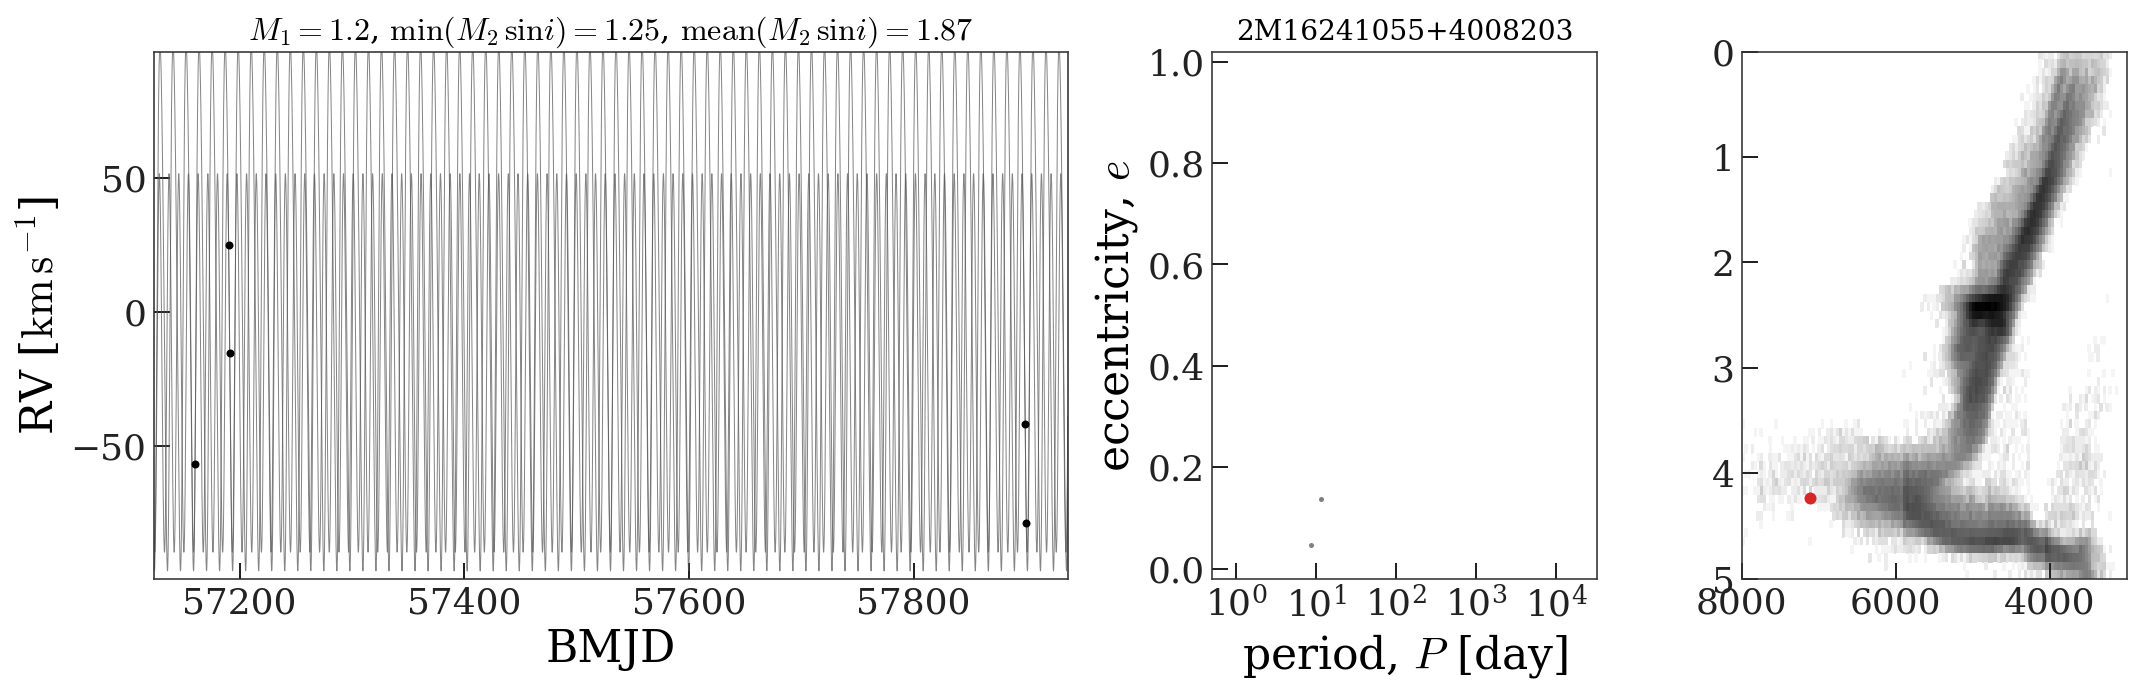

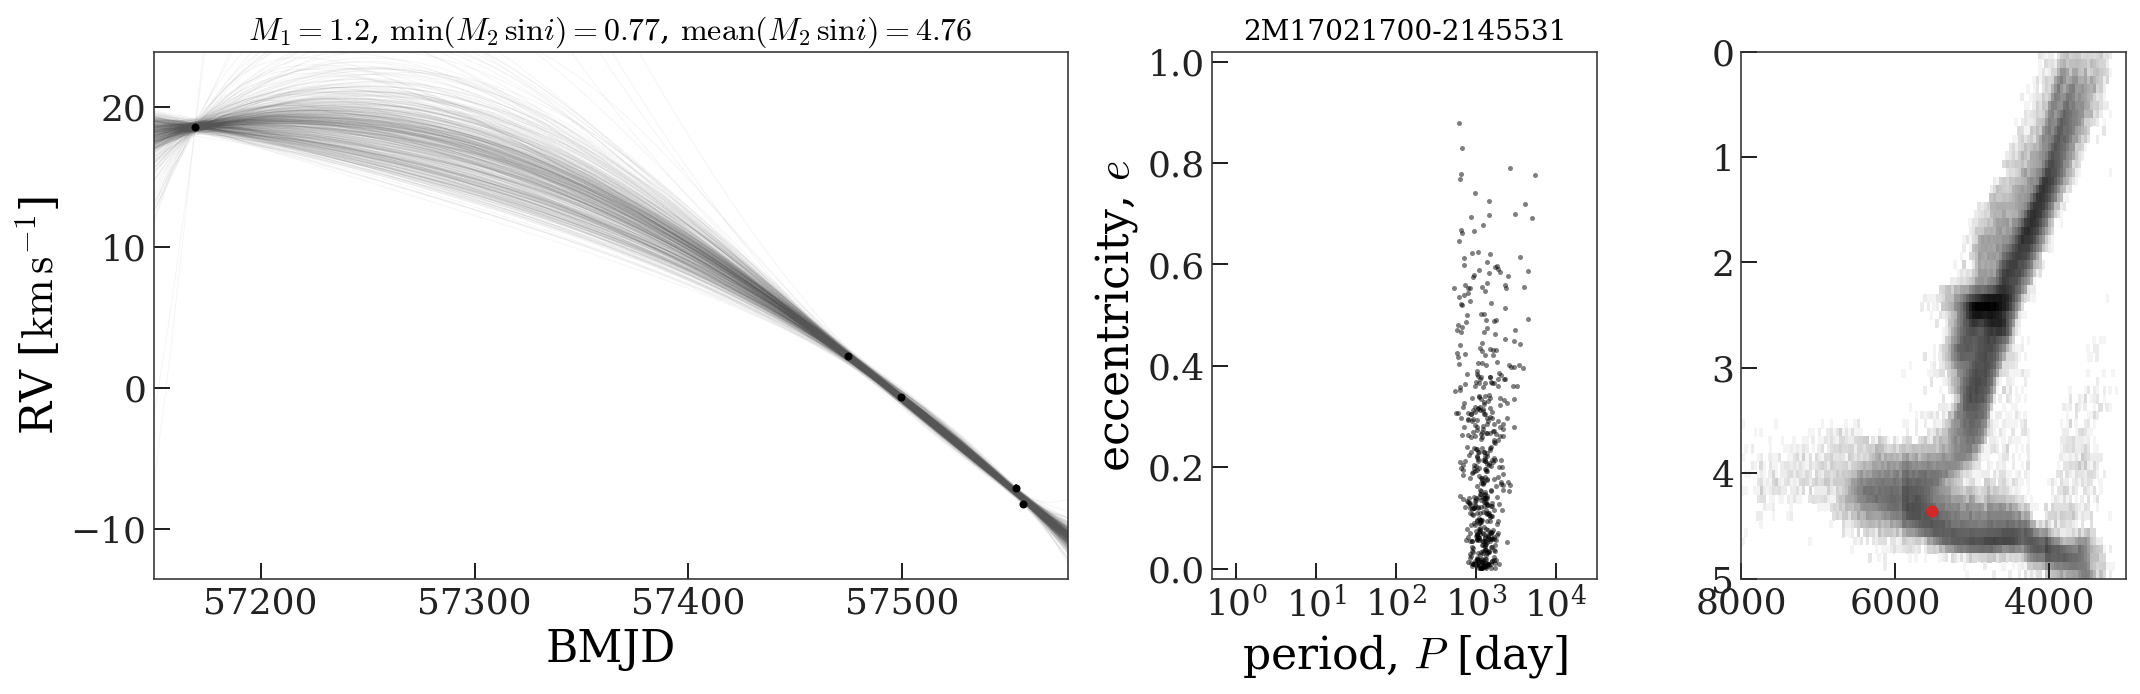

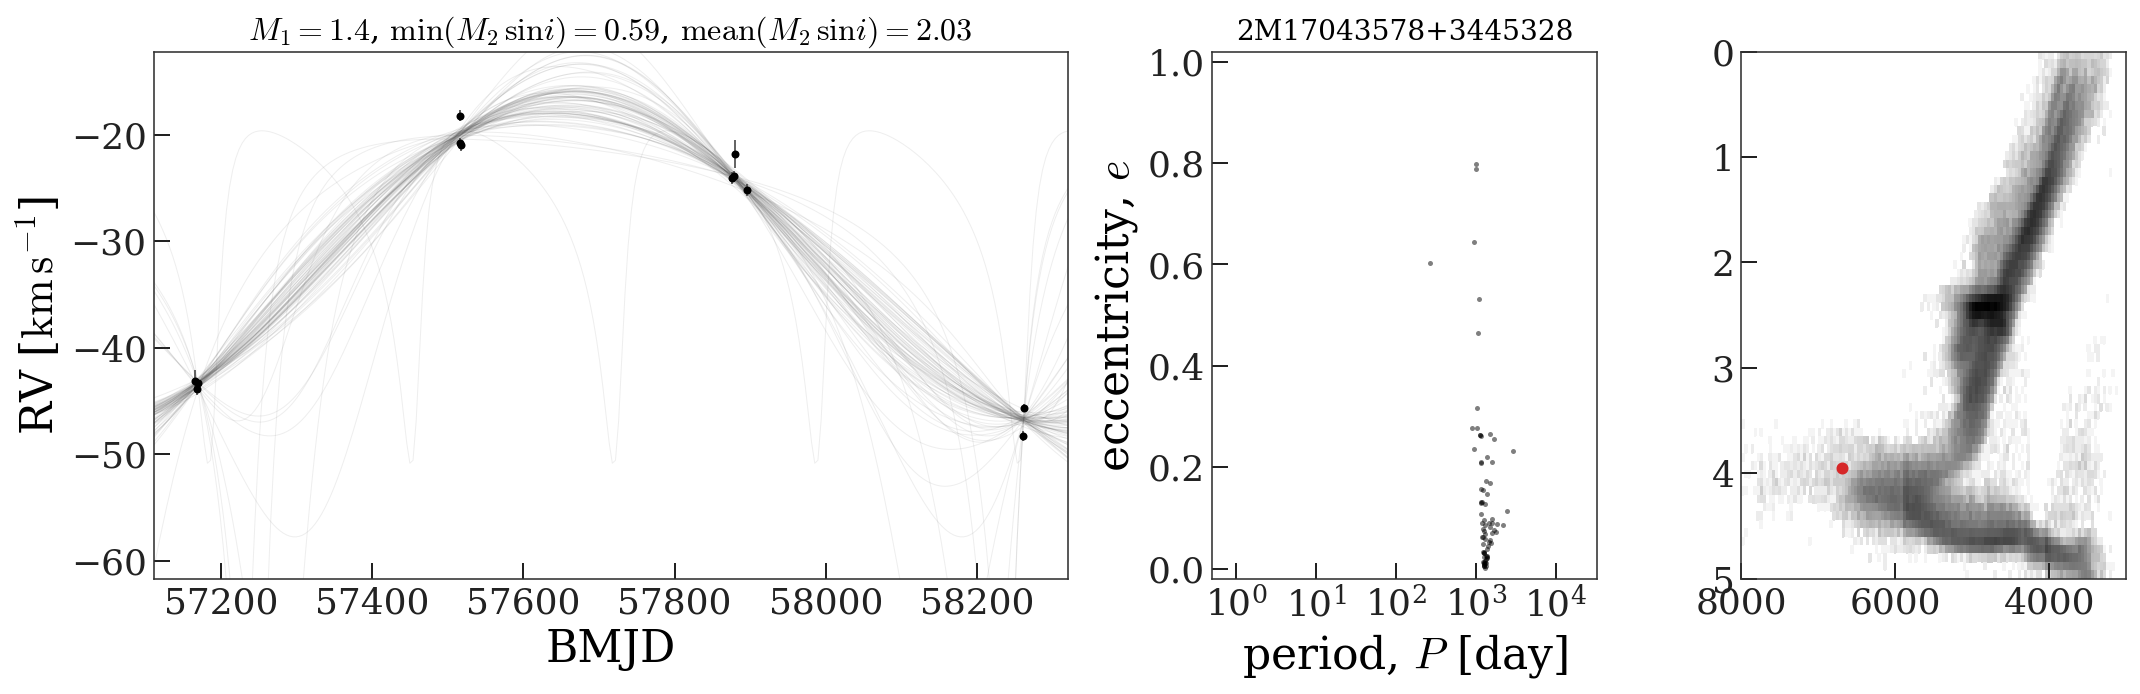

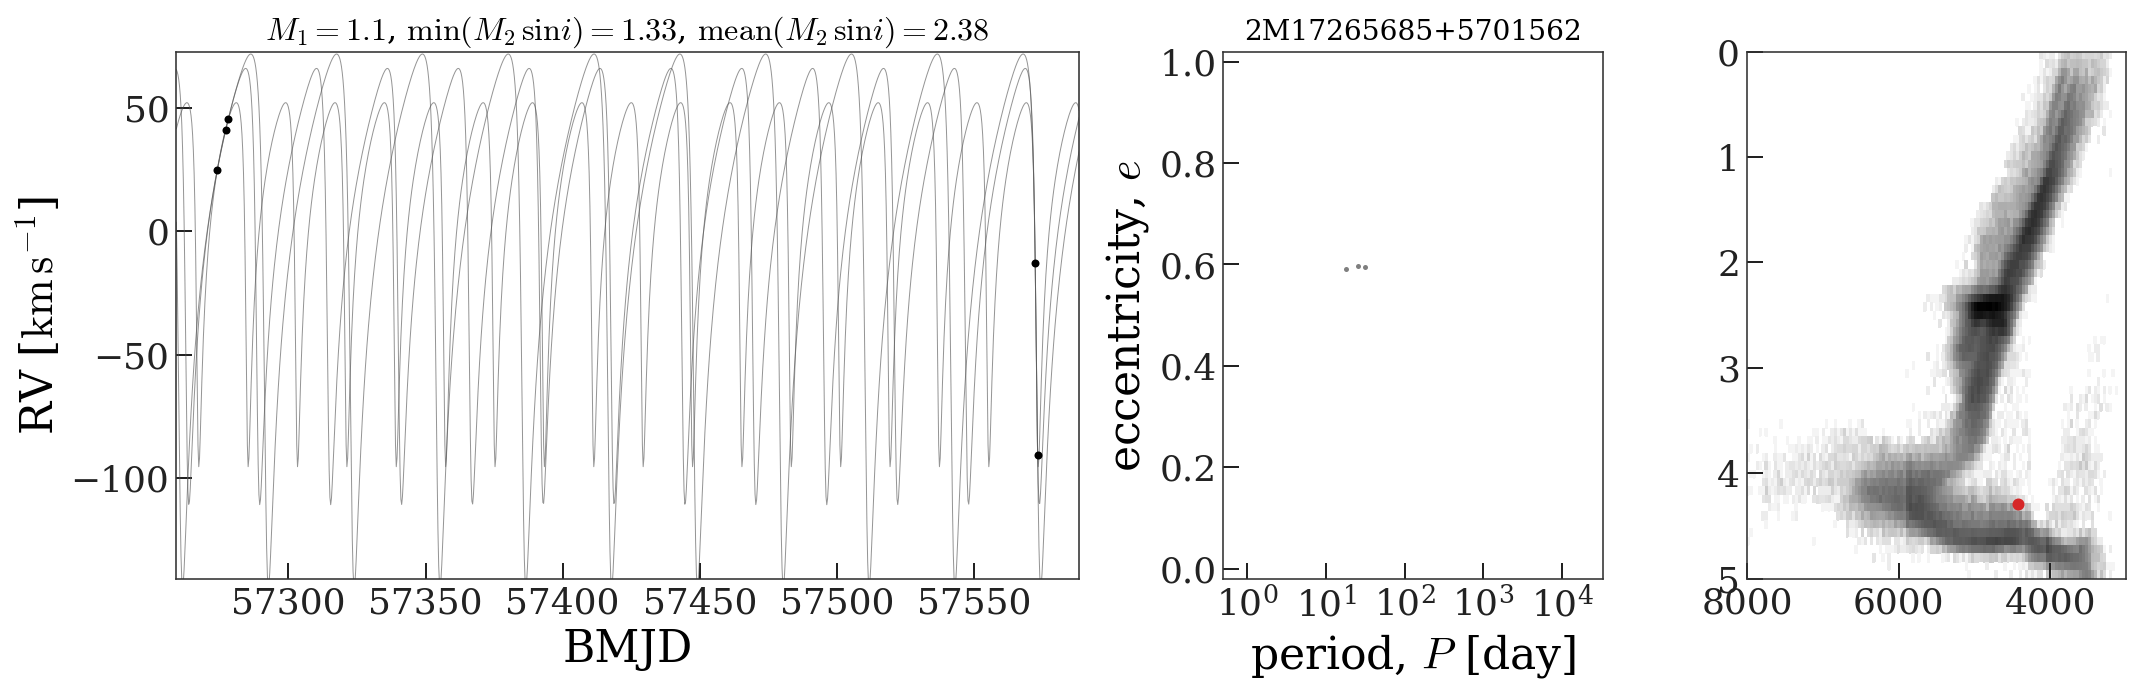

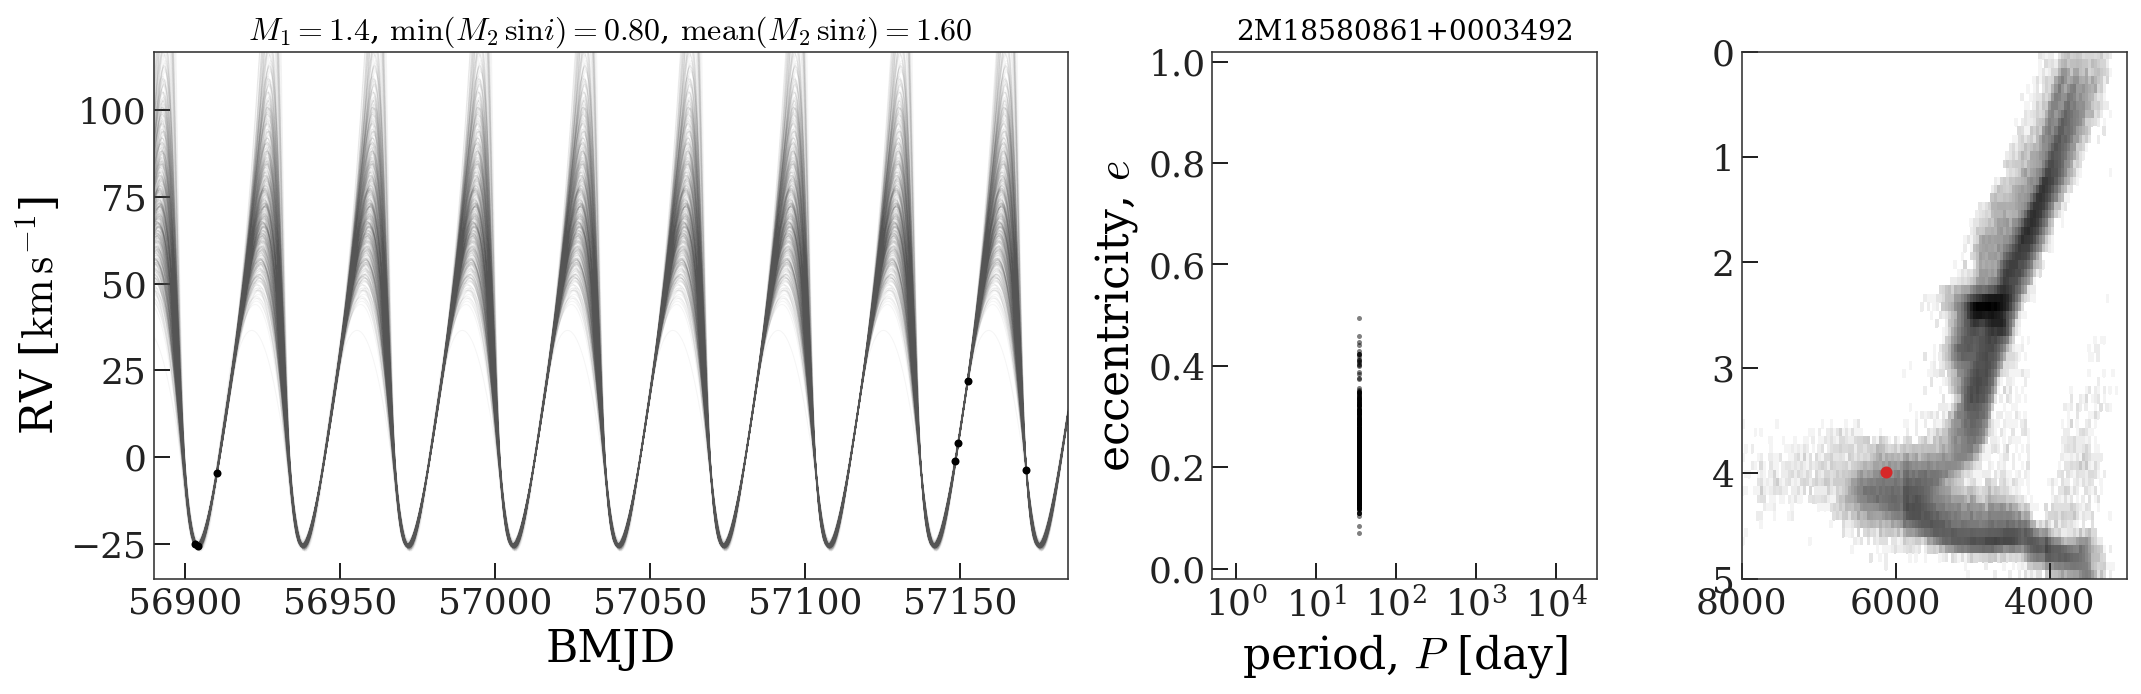

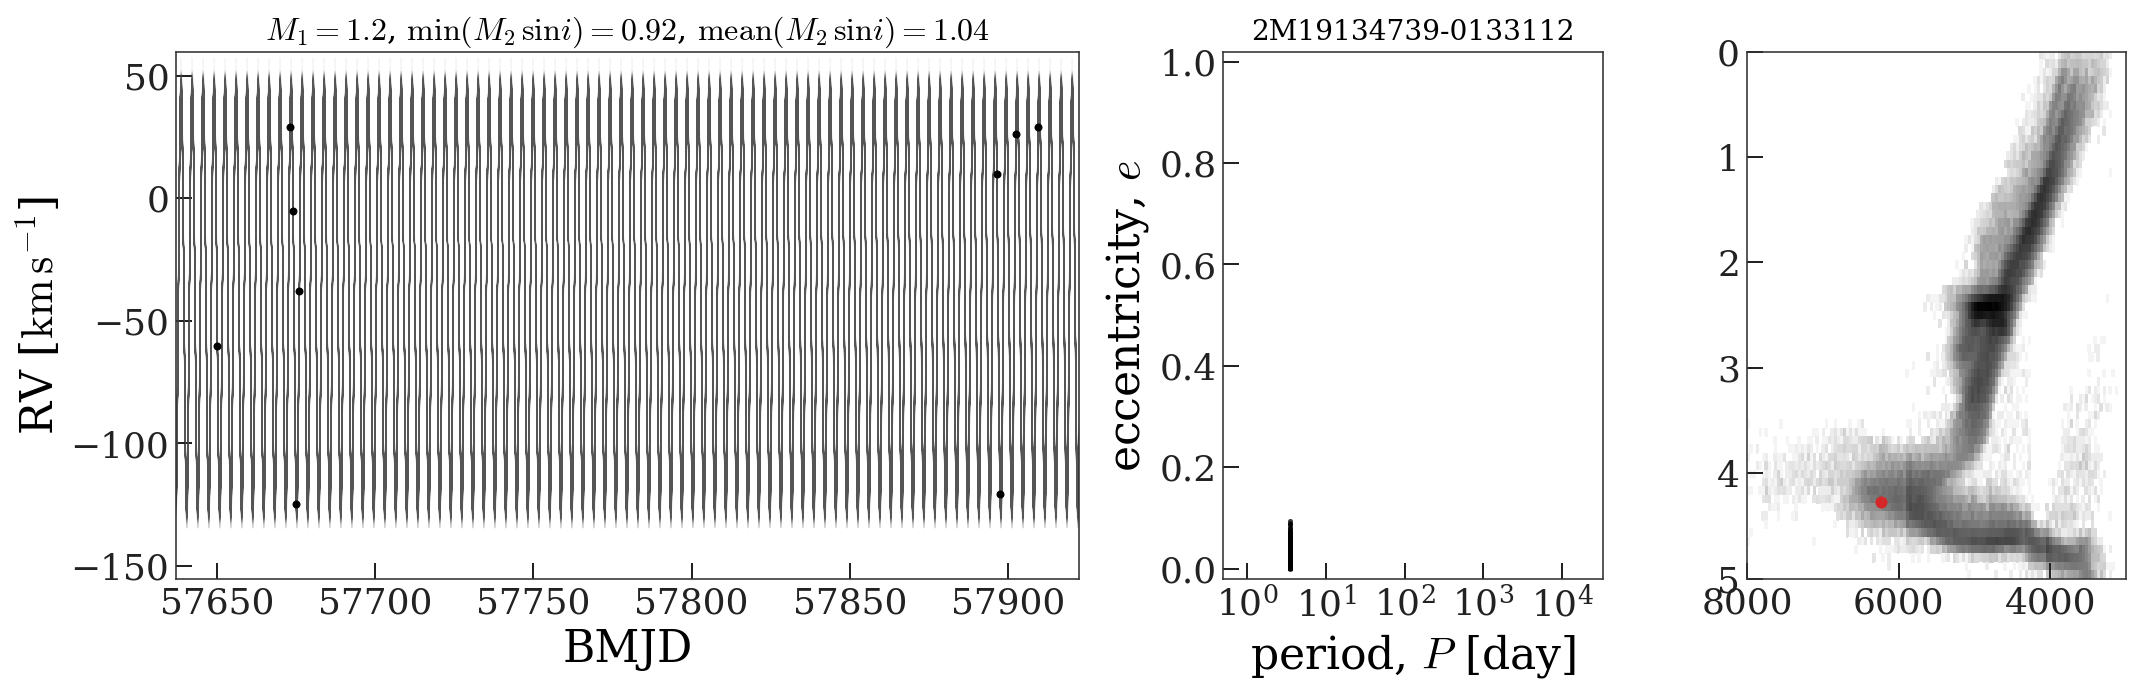

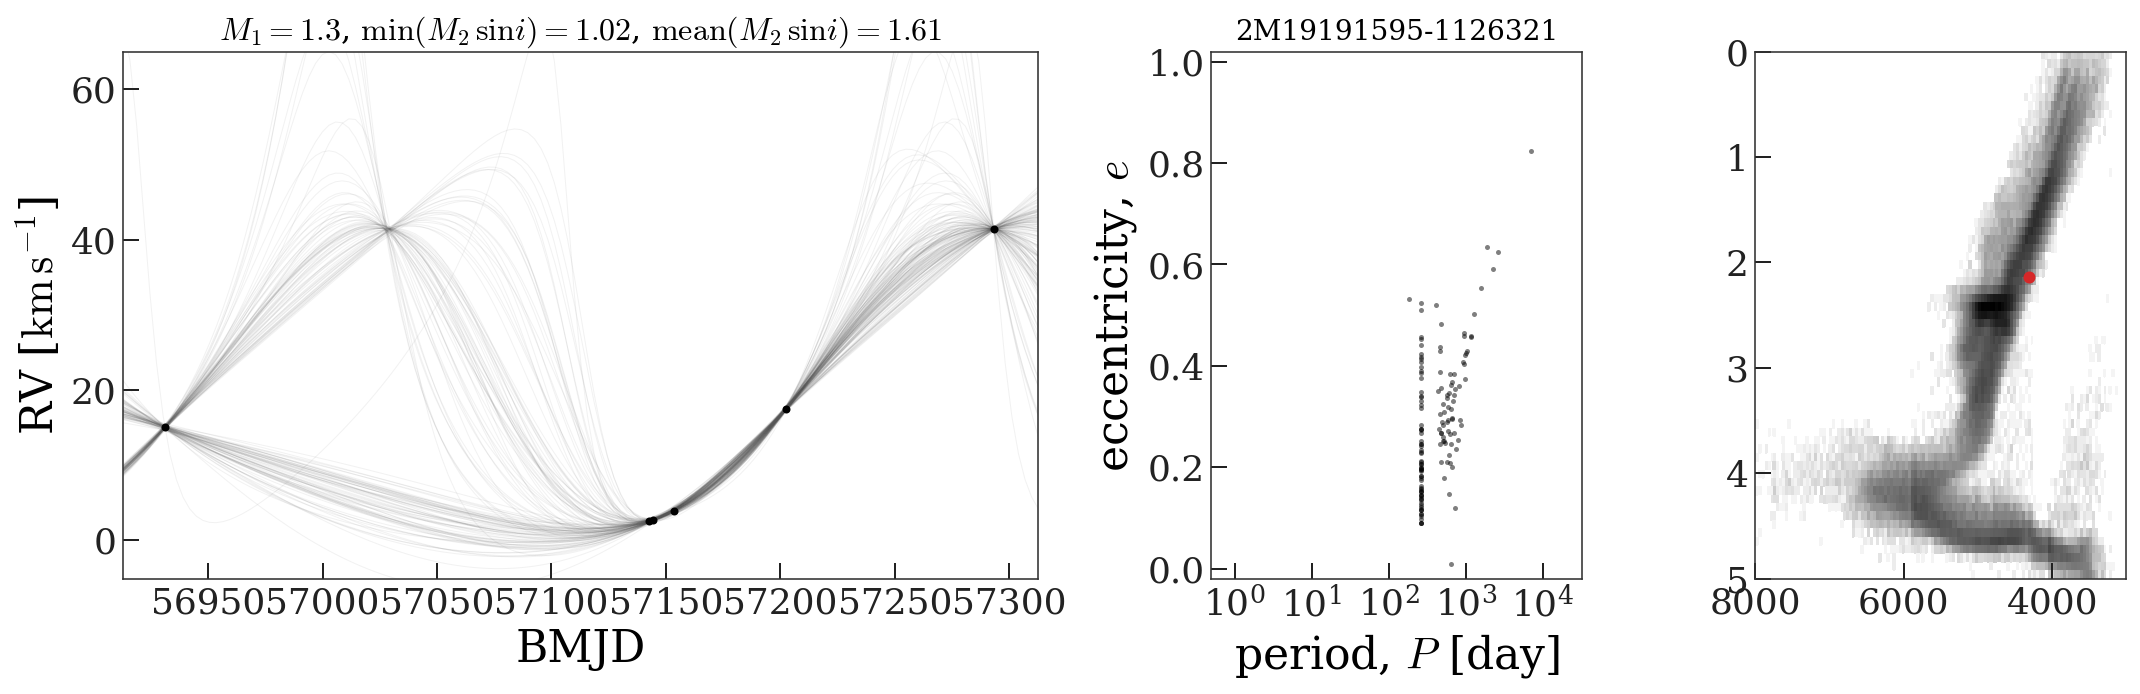

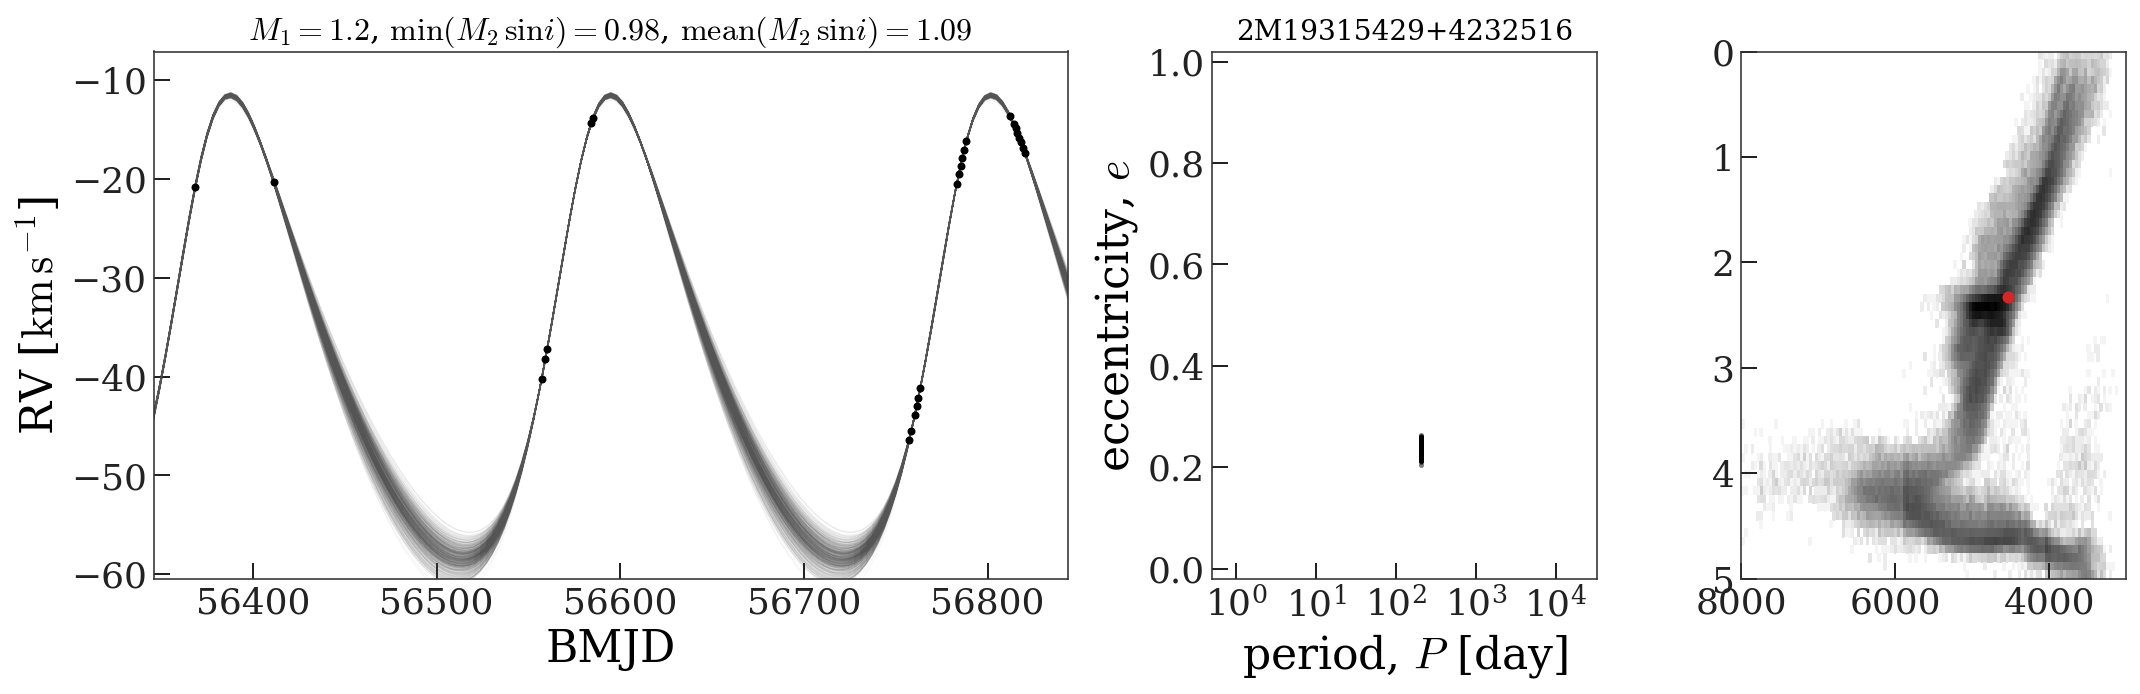

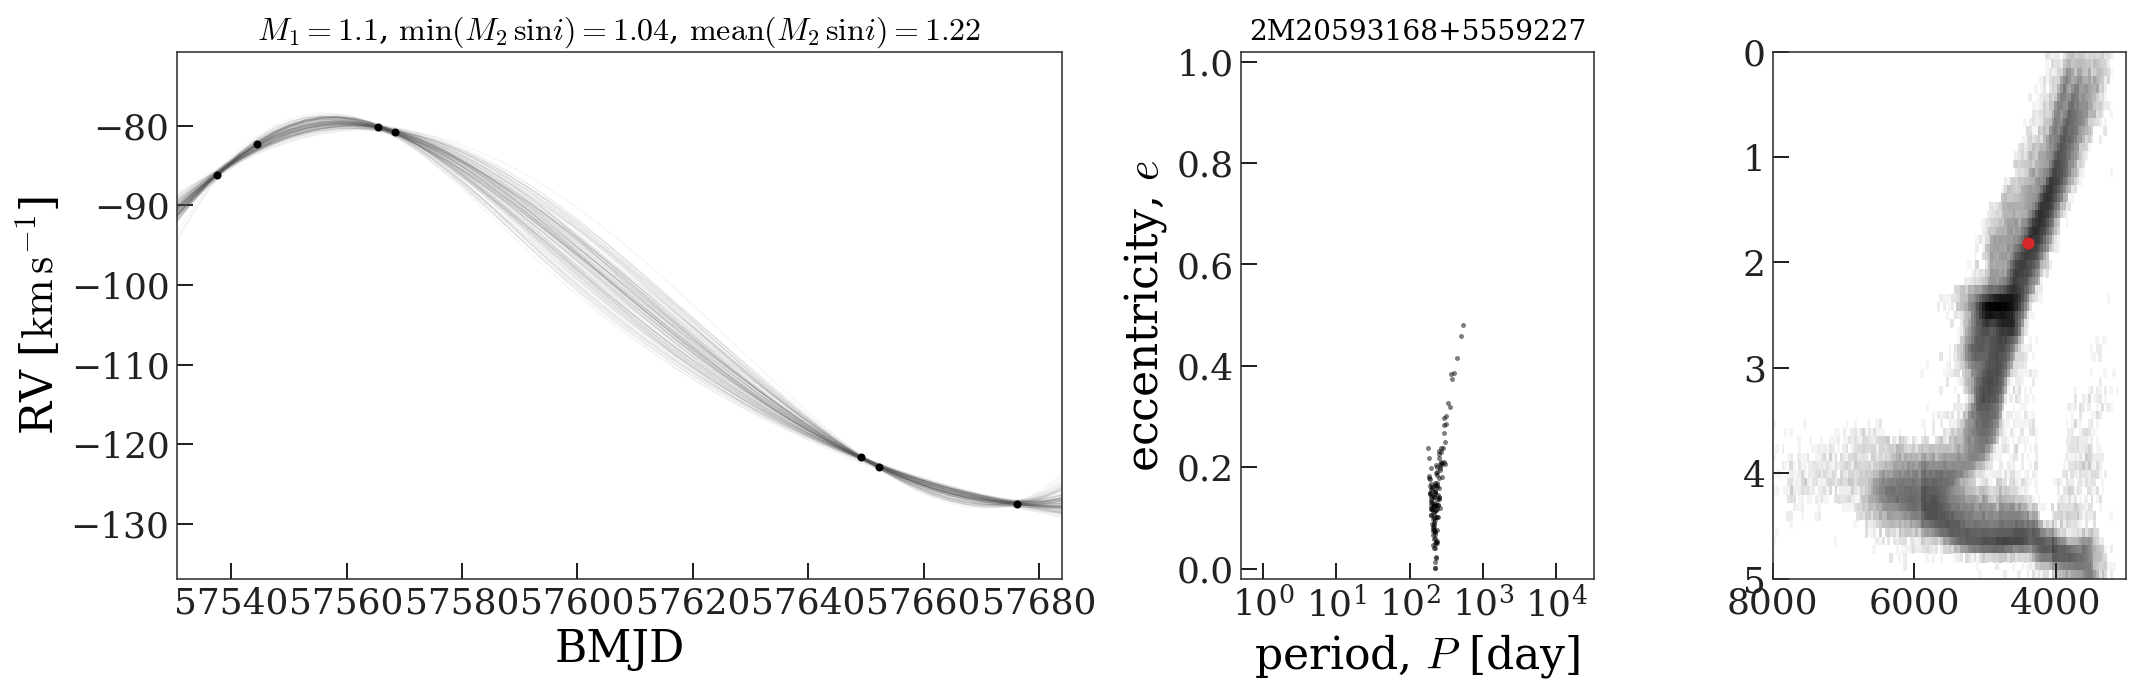

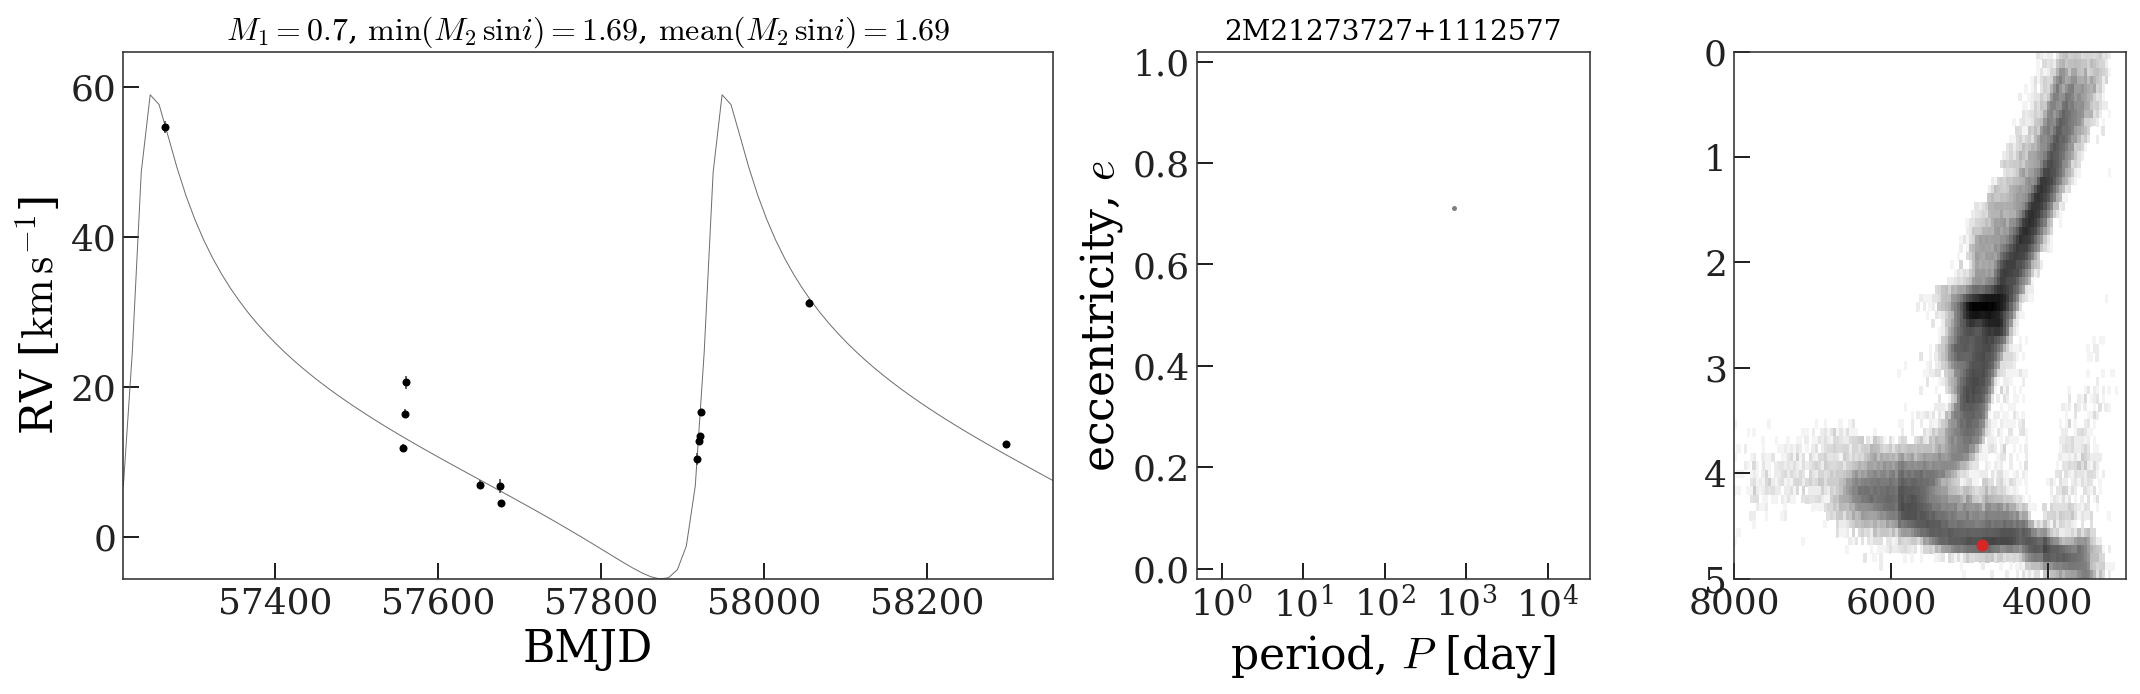

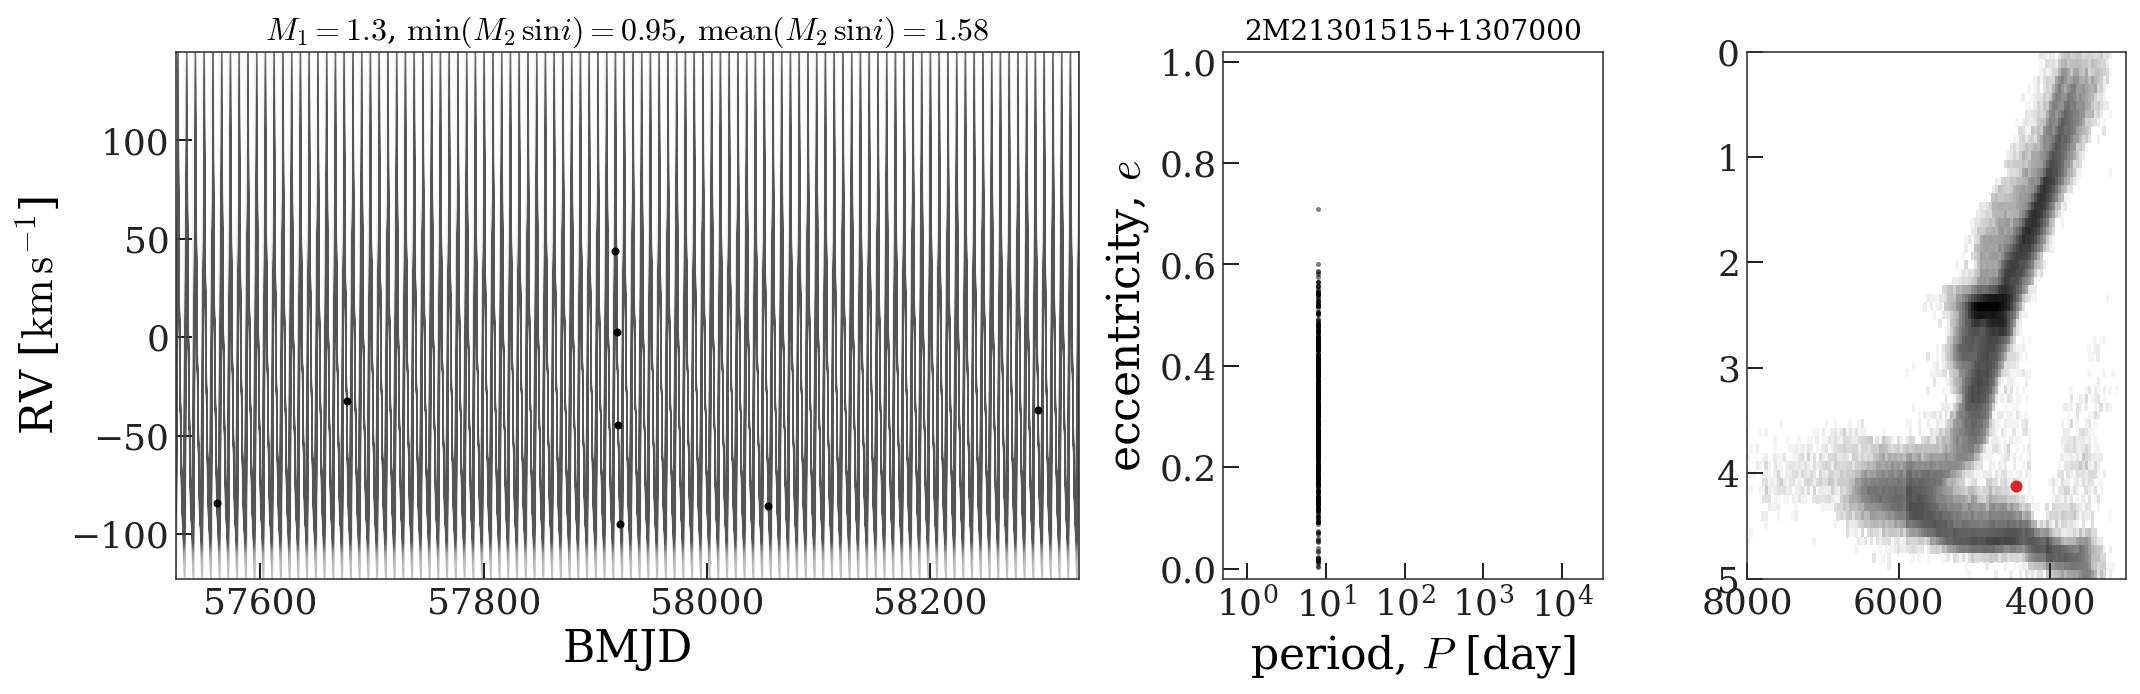

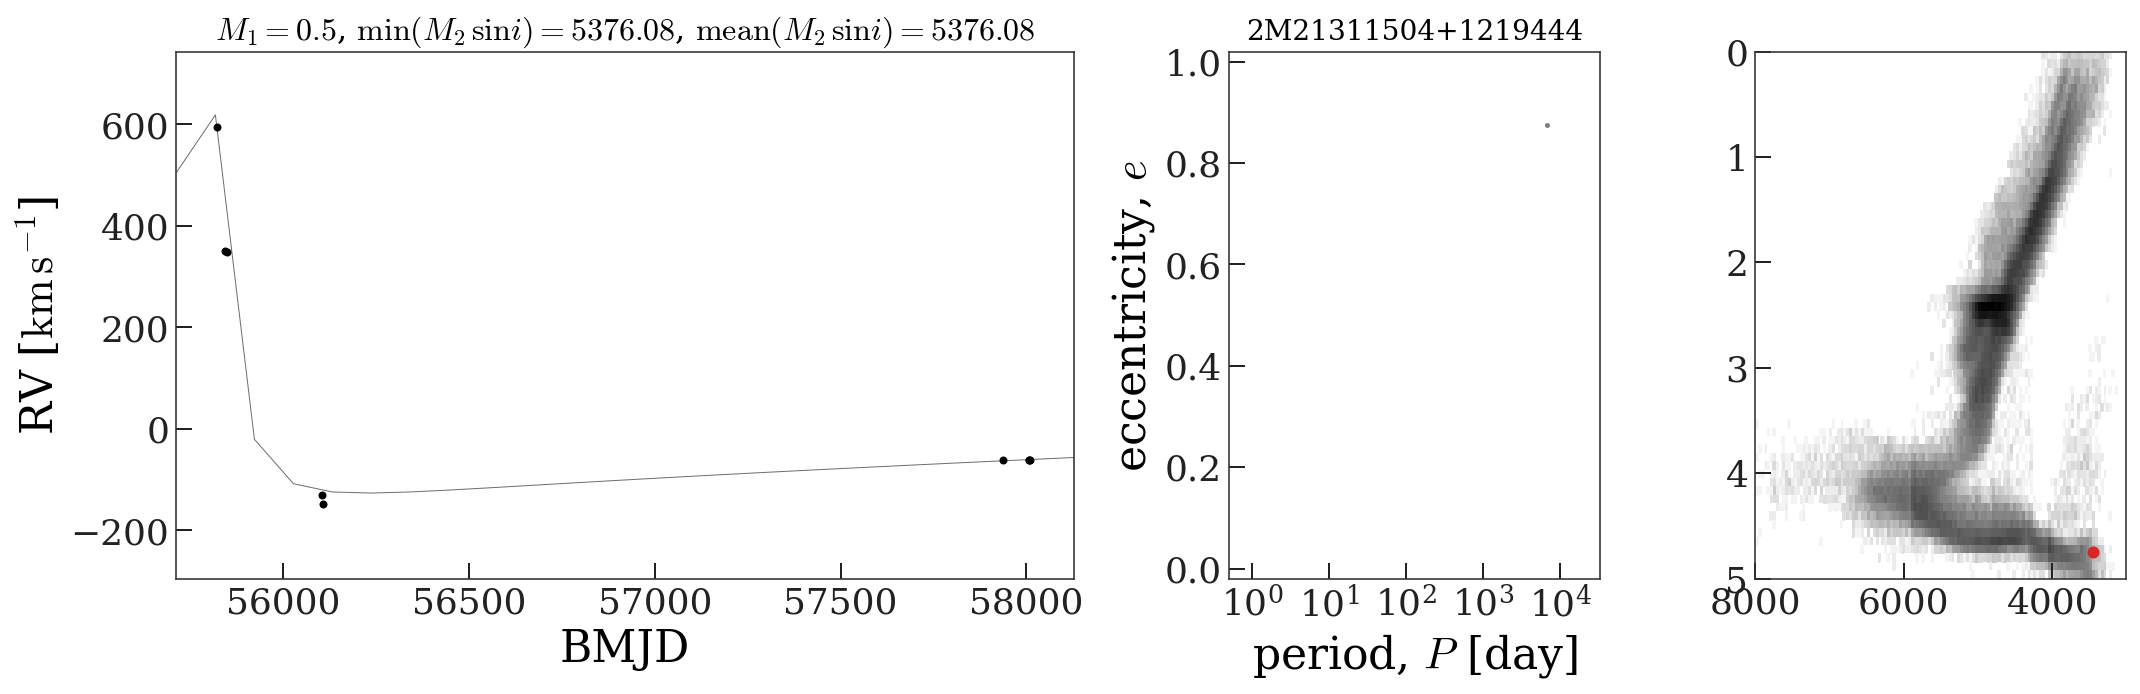

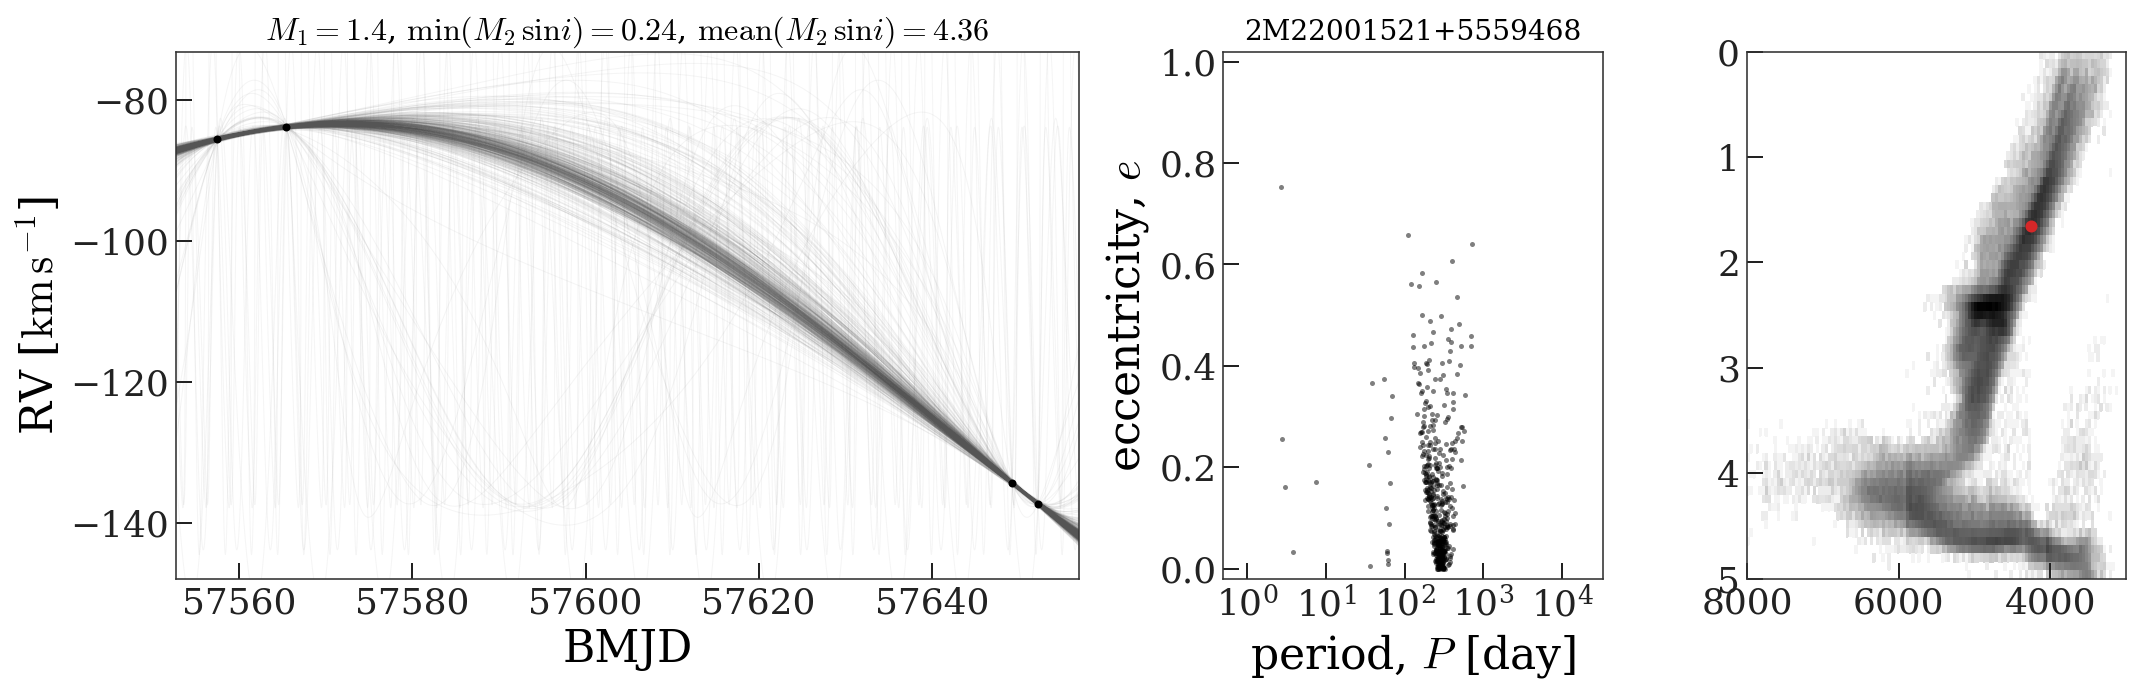

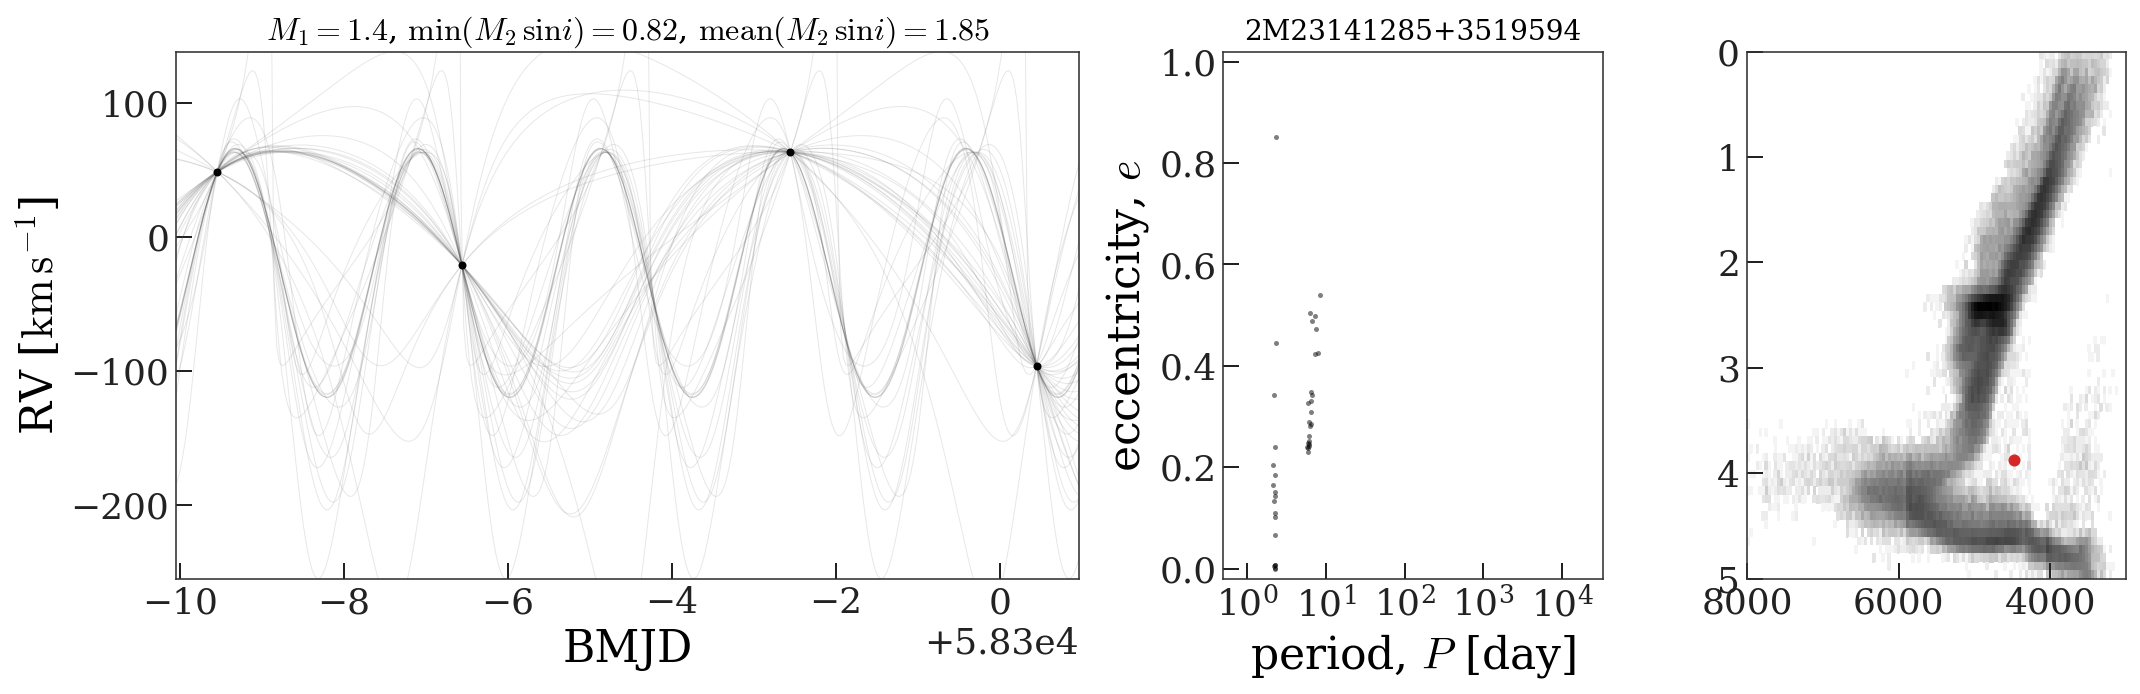

In [156]:
count = 0
for n, (apid, m1, m2_min, samples) in enumerate(zip(cool_ids, m1s, m2_mins, all_samples)):
    data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
    
    if n < 40:
        continue
        
    print(apid)
    
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(nrows=1, ncols=4)
    ax1 = fig.add_subplot(gs[:2])
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])
    
    plot_two_panel(data=data, samples=samples, axes=[ax1, ax2])
    ax1.set_title(fr'$M_1={m1.value:.1f}$, '
                  + fr'${{\rm min}}(M_2 \, \sin i)={m2_min.value.min():.2f}$, '
                  + fr'${{\rm mean}}(M_2 \, \sin i)={m2_min.value.mean():.2f}$',
                  fontsize=16)
    ax2.set_title(apid, fontsize=14)
    
    row = t[t['APOGEE_ID'] == apid]
    ax3.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(), cmap='Greys')
    ax3.scatter(row['TEFF'], row['LOGG'], color='tab:red')
    ax3.set_xlim(8000, 3000)
    ax3.set_ylim(5, 0)
    fig.tight_layout()
    
    count += 1
    
    if count >= 20:
        break

In [89]:
candidates = master[np.isin(master['APOGEE_ID'], cool_ids)]
assert len(candidates) == len(cool_ids)
Table(candidates).write('../../bh/data/candidates.fits', overwrite=True)